# Project title: Binary Classification


#### In this project we will be using the given videos stored in a tensor format that holds 18 different categories of objects inside these videos and also extra information such as the bounding boxes of the objects, coordinates, segmentation masks, depth masks,..etc.

* first we will load the data using the method provided by the professor in the given notebook("project.ipynb").

* then we will divide the videos into frames to facilitate dealing with the data.

* then we will extract the categories of the objects for each frame which will be our labels for the classification task.
* we will explore the data and visualize a sample of it to help us decide which class we will use to apply our Binary Classification task.


* after selecting the class we will use,  we will modify the labels to be 1 for the selected class and 0 for the rest of the classes.


* finally we will apply some preprocessing techniques to prepare the data for the classification task.



# Import library

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter
import time
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

c:\Users\Shenhapy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load data

In [2]:
PROJECT_ROOT_DIR = r"E:\OneDrive - University of Ottawa\CV\CV Project"
data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data/tensorflow_data/')
os.makedirs(data_path, exist_ok=True)
print("Using directory: ", data_path)

Using directory:  E:\OneDrive - University of Ottawa\CV\CV Project\tensorflow_data/tensorflow_data/


In [3]:
flow_data_set_linear = tfds.load('elg7186_projectdata/linear_movement_rotate', data_dir=data_path)
flow_data_set_rotation = tfds.load('elg7186_projectdata/rotation_rotate', data_dir=data_path)
flow_data_set_fixed = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)

In [4]:
def make_df(data_set):
    df_list = []  # Create a list to hold DataFrames
    iter_data = iter(data_set['train'])

    for i in range(len(data_set['train'])):
        train_data = next(iter_data)
        video_frames = []

        for j in range(len(train_data['video'])):
            video_frames.append({'img': np.array(train_data['video'][j, :, :, :]),
                                 'y': train_data['instances']['category'].numpy()})

        df_list.append(pd.DataFrame(video_frames))

    return pd.concat(df_list, ignore_index=True)

# Create dataframes for each dataset
df_linear = make_df(flow_data_set_linear)  # 720 frames
df_fixed = make_df(flow_data_set_fixed)    # 720 frames
df_rot = make_df(flow_data_set_rotation)   # 720 frames

# Concatenate the dataframes into one dataframe
df = pd.concat([df_linear, df_fixed, df_rot], ignore_index=True)  # 2160 frames


In [5]:
df.sample(5)

,img,y
1051,"[[[213, 168, 129], [217, 174, 134], [221, 179,...",[13]
75,"[[[140, 137, 126], [139, 136, 126], [141, 138,...","[1, 6, 11]"
1899,"[[[223, 184, 147], [222, 182, 144], [220, 180,...","[14, 13, 14]"
541,"[[[198, 165, 90], [199, 165, 90], [199, 165, 9...",[6]
85,"[[[134, 129, 119], [133, 129, 118], [134, 130,...","[1, 6, 11]"


In [6]:
# Flatten the 'y' column and count occurrences of each label
label_counts = {}
for sublist in df['y']:
    for labels in sublist:
        if isinstance(labels, list):
            for label in labels:
                if label[0] in label_counts:
                    label_counts[label[0]] += 1
                else:
                    label_counts[label[0]] = 1

# Fill missing labels with zero counts
for i in range(16):
    if i not in label_counts:
        label_counts[i] = 0

# Sort the dictionary by keys
label_counts = dict(sorted(label_counts.items()))

print("Label Counts:")
print(label_counts)

Label Counts:
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [7]:
# datasets shapes
print(df_linear.shape)
print(df_fixed.shape)
print(df_rot.shape)

(720, 2)
(720, 2)
(720, 2)


# visualizing some examples

In [8]:
df_rot.sample(5)

,img,y
373,"[[[129, 128, 123], [125, 124, 119], [123, 122,...",[6]
556,"[[[201, 91, 53], [201, 90, 53], [200, 89, 52],...","[13, 14, 16, 14, 14, 14, 14]"
375,"[[[129, 129, 125], [129, 128, 124], [131, 130,...",[6]
367,"[[[117, 116, 112], [116, 116, 112], [120, 120,...",[6]
667,"[[[139, 150, 158], [145, 155, 164], [125, 135,...","[13, 13, 1]"


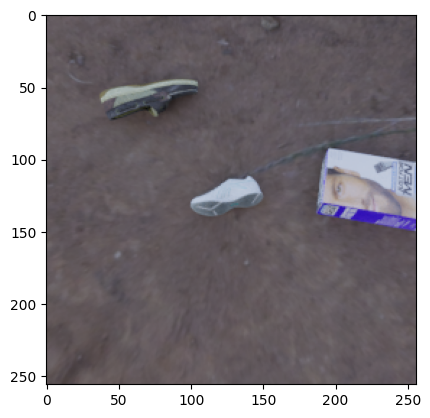

In [9]:
plt.imshow(np.array(df_rot['img'][426]))

# sample of data

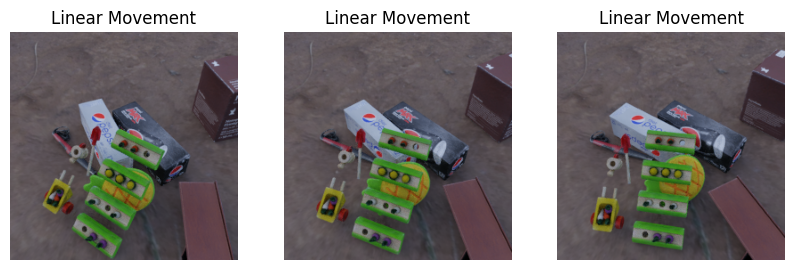

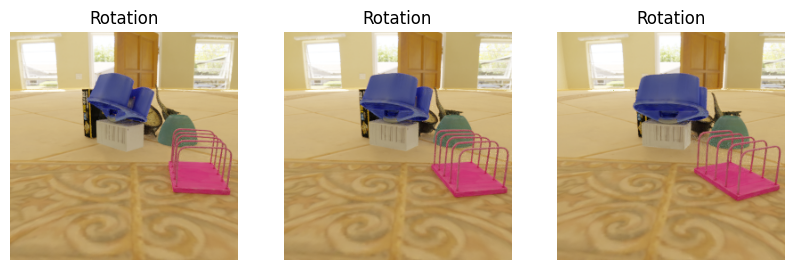

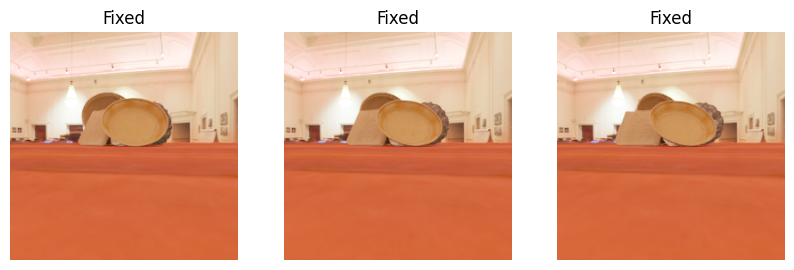

In [10]:
# in this section we will visualize the data by plotting some images from each dataset to see the difference between them

#linear move dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_linear['img'][0])
ax[0].set_title('Linear Movement')
ax[0].axis('off')
ax[1].imshow(df_linear['img'][1])
ax[1].set_title('Linear Movement')
ax[1].axis('off')
ax[2].imshow(df_linear['img'][2])
ax[2].set_title('Linear Movement')
ax[2].axis('off')
plt.show()

# rotation dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_rot['img'][0])
ax[0].set_title('Rotation')
ax[0].axis('off')
ax[1].imshow(df_rot['img'][1])
ax[1].set_title('Rotation')
ax[1].axis('off')
ax[2].imshow(df_rot['img'][2])
ax[2].set_title('Rotation')
ax[2].axis('off')
plt.show()


#fixed dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_fixed['img'][0])
ax[0].set_title('Fixed')
ax[0].axis('off')
ax[1].imshow(df_fixed['img'][1])
ax[1].set_title('Fixed')
ax[1].axis('off')
ax[2].imshow(df_fixed['img'][2])
ax[2].set_title('Fixed')
ax[2].axis('off')
plt.show()

In [11]:
# getting the most frequent class to classify based on it to gurantee data balance
from collections import Counter
Counter([item for sublist in df['y'] for item in sublist]).most_common(1)

[(14, 2208)]

In [12]:
# Get counts of each element in 'y' column
counts = Counter(item for sublist in df['y'] for item in sublist)
print(counts)

Counter({14: 2208, 6: 2064, 13: 1752, 16: 888, 1: 216, 0: 216, 3: 192, 11: 72, 10: 72, 9: 72, 12: 48})


# make a copy from the dataframe to keep the original one away from modification

In [13]:
import copy
df_copy = copy.deepcopy(df)
df_copy['z'] = df_copy['y'].apply(lambda x: 1 if 14 in x else 0)  # 14 is shoe

In [14]:
df_copy.sample(5)

,img,y,z
1004,"[[[207, 233, 235], [206, 232, 234], [205, 232,...",[6],0
1438,"[[[192, 81, 47], [196, 80, 47], [200, 82, 47],...",[16],0
1695,"[[[223, 187, 154], [223, 186, 151], [223, 186,...",[13],0
1431,"[[[192, 81, 47], [196, 80, 47], [199, 82, 47],...",[16],0
978,"[[[171, 168, 173], [170, 170, 177], [167, 161,...","[14, 14, 9]",1


## Now we should check for the data balance to avoid any problems that may appear due to data imbalance

Text(0.5, 1.0, 'Histogram of Shoe(1) vs. Non-Shoe(0)')

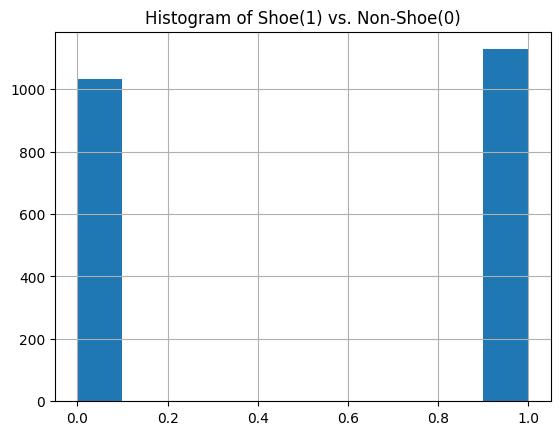

In [15]:
df_copy['z'].hist()
title = 'Histogram of Shoe(1) vs. Non-Shoe(0)'
plt.title(title)

## As we see the chosen class "shoe" (14) is a great choice for our binary classification problem

# Image preprocessing

In [16]:
# This function is used to preprocess the images by resizing them to 128x128,
# then enhancing them using unsharp mask, then denoising them

def preprocess_image(img, desired_size=(128, 128)):
    # Resizing
    img = resize(img, desired_size)

    # Enhancing the image using unsharp mask
    # img = unsharp_mask(img)

    # Denoising
    # sigma_est = np.mean(estimate_sigma(img))
    # img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True)

    # Histogram Equalization for enhancing contrast
    # img = equalize_hist(img)

    # Convert to grayscale
    # gray_img = rgb2gray(img)

    # Expand the dimensions to fit the model input shape
    return np.expand_dims(img, axis=-1)

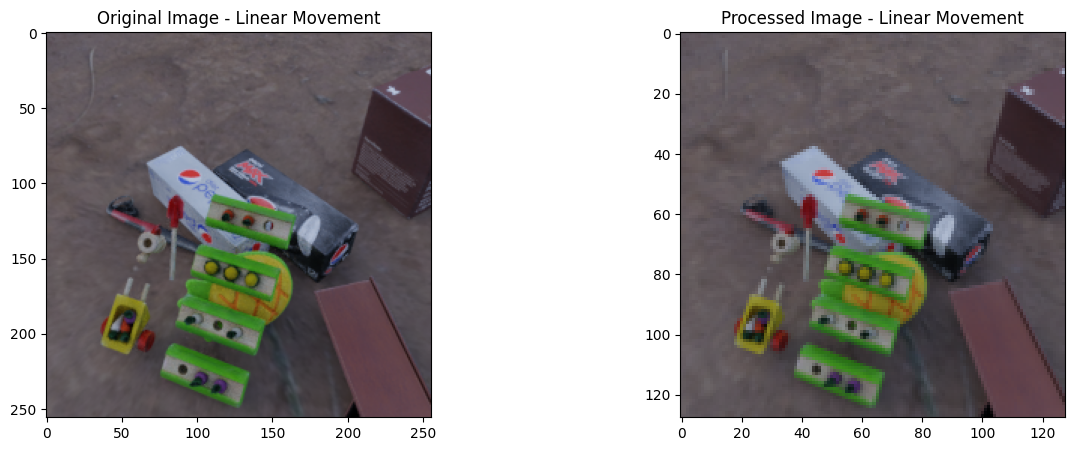

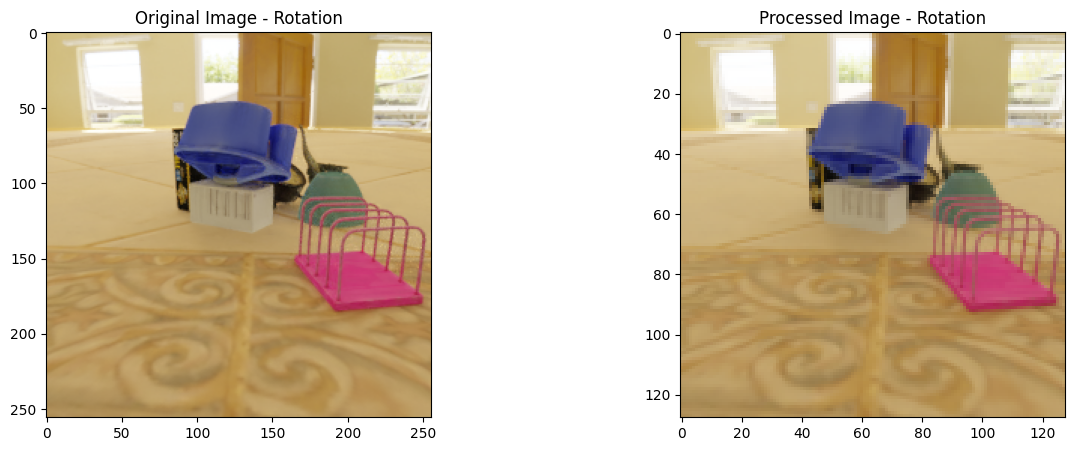

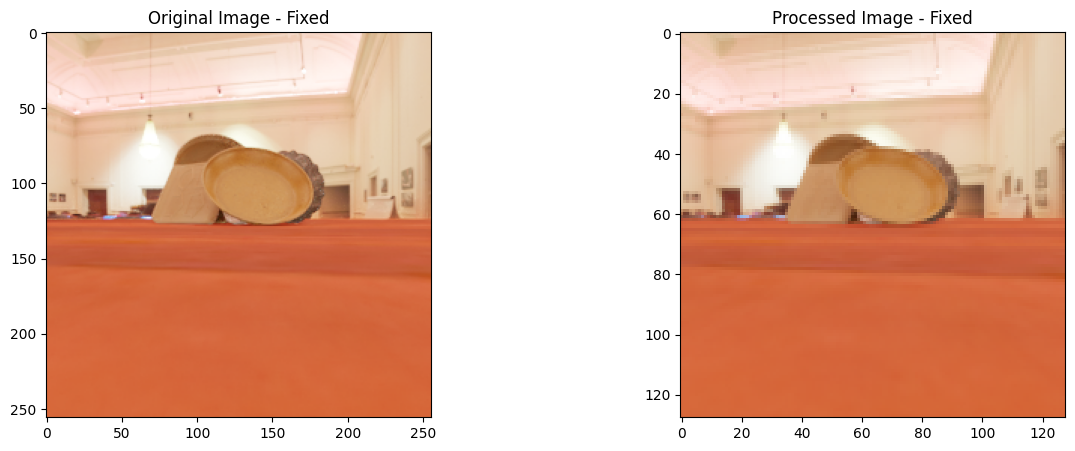

In [17]:
# this function is used to display the images before and after preprocessing
def display_image_processing(df, title):
      img = df['img'][1]
      processed_img = preprocess_image(img)
      fig, ax = plt.subplots(1, 2, figsize=(15, 5))
      ax[0].imshow(img)
      ax[0].set_title(f"Original Image - {title}")
      ax[1].imshow(processed_img.squeeze(), cmap='gray')
      ax[1].set_title(f"Processed Image - {title}")
      plt.show()

# Display for each dataframe
display_image_processing(df_linear, 'Linear Movement')
display_image_processing(df_rot, 'Rotation')
display_image_processing(df_fixed, 'Fixed')

## Now the data is ready for the training step

In [18]:
df_copy_preprocess = copy.deepcopy(df_copy)

# Apply preprocessing to all images
df_copy_preprocess['img'] = df_copy_preprocess['img'].apply(preprocess_image)

In [47]:
train_data, temp_data = train_test_split(df_copy_preprocess, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

# Convert the list of processed images into an array
X_train = np.array(train_data['img'].tolist())
X_test = np.array(test_data['img'].tolist())
X_val = np.array(val_data['img'].tolist())

# Labels
y_train = train_data['z'].values
y_test = test_data['z'].values
y_val = val_data['z'].values

# Evaluation Functions

In [20]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Evaluate the model on the training set
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    train_pred = (model.predict(X_train) > 0.5).astype(int)
    train_cm = confusion_matrix(y_train, train_pred)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    val_pred = (model.predict(X_val) > 0.5).astype(int)
    val_cm = confusion_matrix(y_val, val_pred)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_pred = (model.predict(X_test) > 0.5).astype(int)
    test_cm = confusion_matrix(y_test, test_pred)

    # Plotting Confusion Matrices
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    sns.heatmap(train_cm, annot=True, cmap='Pastel2', ax=axs[0], fmt='g')
    axs[0].set_title('Training Confusion Matrix')
    axs[0].set_xlabel('Predicted Labels')
    axs[0].set_ylabel('Actual Labels')

    sns.heatmap(val_cm, annot=True, cmap='Pastel1', ax=axs[1], fmt='g')
    axs[1].set_title('Validation Confusion Matrix')
    axs[1].set_xlabel('Predicted Labels')
    axs[1].set_ylabel('Actual Labels')

    sns.heatmap(test_cm, annot=True, cmap='Pastel2', ax=axs[2], fmt='g')
    axs[2].set_title('Testing Confusion Matrix')
    axs[2].set_xlabel('Predicted Labels')
    axs[2].set_ylabel('Actual Labels')

    plt.tight_layout()
    plt.show()

    return train_cm,val_cm,test_cm

In [21]:
def evaluate_model_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    def calculate_metrics(X, y):
        y_pred = model.predict(X)
        y_pred_classes = (y_pred > 0.5).astype(int)

        accuracy = accuracy_score(y, y_pred_classes)
        f1 = f1_score(y, y_pred_classes)
        loss = model.evaluate(X, y, verbose=0)[0]

        return accuracy, f1, loss, classification_report(y, y_pred_classes)

    train_accuracy, train_f1, train_loss, train_classification_report = calculate_metrics(X_train, y_train)
    val_accuracy, val_f1, val_loss, val_classification_report = calculate_metrics(X_val, y_val)
    test_accuracy, test_f1, test_loss, test_classification_report = calculate_metrics(X_test, y_test)

    results = {
        'Training': {
            'Accuracy': train_accuracy,
            'F1 Score': train_f1,
            'Loss': train_loss,
            'Classification Report': train_classification_report
        },
        'Validation': {
            'Accuracy': val_accuracy,
            'F1 Score': val_f1,
            'Loss': val_loss,
            'Classification Report': val_classification_report
        },
        'Test': {
            'Accuracy': test_accuracy,
            'F1 Score': test_f1,
            'Loss': test_loss,
            'Classification Report': test_classification_report
        }
    }

    return results


In [22]:
def plot_learning_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


# Modeling

## ResNet50

ResNet50 is a powerful deep learning model for binary classification tasks. It comprises 50 layers of convolutional neural networks that allow for the extraction of intricate features from images. By utilizing skip connections, ResNet50 mitigates the vanishing gradient problem, enhancing training efficiency and enabling accurate classification between two classes.

In [23]:
def build_and_train_modelResNet50(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define the base model using ResNet50
    input_tensor = Input(shape=(128, 128, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add new classifier layers
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Define the new model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    start_time = time.time()
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=100,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        epochs=32
    )
    end_time = time.time()
    training_time = end_time - start_time
    
    # Evaluate the model on train, validation, and test sets
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    y_train_pred = model.predict(X_train)
    train_cm = confusion_matrix(y_train, y_train_pred > 0.5)

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    y_val_pred = model.predict(X_val)
    val_cm = confusion_matrix(y_val, y_val_pred > 0.5)

    start_time = time.time()
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    end_time = time.time()
    evaluate_time = end_time - start_time

    start_time = time.time()
    y_test_pred = model.predict(X_test)
    end_time = time.time()
    predict_time = end_time - start_time

    test_cm = confusion_matrix(y_test, y_test_pred > 0.5)

    print("Training Time:", training_time)
    print("Evaluation Time:", evaluate_time)
    print("Prediction Time:", predict_time)

    print("\nTraining Confusion Matrix:")
    print(train_cm)
    print("\nValidation Confusion Matrix:")
    print(val_cm)
    print("\nTest Confusion Matrix:")
    print(test_cm)

        # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_pred > 0.5)

    loss = model.evaluate(X_test, y_test, verbose=0)[0]

    # Calculate F1 score
    f1 = f1_score(y_test, y_test_pred > 0.5)

    # Print or use these metrics as needed
    print("Accuracy:", accuracy)
    print("Loss:", loss)
    print("F1 Score:", f1)


    # Calculate approximate memory usage based on model trainable variables
    total_parameters = 0
    for variable in model.trainable_variables:
        shape = variable.shape
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim
        total_parameters += variable_parameters

    approximate_memory = total_parameters * 4  # Assuming each parameter is a float32 (4 bytes)
    print("Approximate memory usage of the model (in bytes):", approximate_memory)

    # Display model summary to get an estimate of memory usage
    print(model.summary())


    return training_time, evaluate_time, predict_time, train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history


In [24]:
resnet_training_time, resnet_evaluate_time, resnet_predict_time, train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, ResNet50_model, history = build_and_train_modelResNet50(X_train, y_train, X_val, y_val, X_test, y_test)


Epoch 1/32
16/16 [==============================] - 27s 1s/step - loss: 1.1660 - accuracy: 0.5172 - val_loss: 0.6470 - val_accuracy: 0.5895
Epoch 2/32
16/16 [==============================] - 23s 1s/step - loss: 0.8240 - accuracy: 0.5291 - val_loss: 0.6319 - val_accuracy: 0.6944
Epoch 3/32
16/16 [==============================] - 23s 1s/step - loss: 0.6624 - accuracy: 0.5893 - val_loss: 0.6098 - val_accuracy: 0.6790
Epoch 4/32
16/16 [==============================] - 23s 1s/step - loss: 0.6294 - accuracy: 0.6501 - val_loss: 0.6169 - val_accuracy: 0.6944
Epoch 5/32
16/16 [==============================] - 22s 1s/step - loss: 0.6227 - accuracy: 0.6455 - val_loss: 0.5847 - val_accuracy: 0.7377
Epoch 6/32
16/16 [==============================] - 22s 1s/step - loss: 0.6038 - accuracy: 0.6739 - val_loss: 0.5968 - val_accuracy: 0.7160
Epoch 7/32
16/16 [==============================] - 23s 1s/step - loss: 0.5949 - accuracy: 0.6865 - val_loss: 0.5674 - val_accuracy: 0.7130
Epoch 8/32
16/16 [==

In [25]:
# Calculate approximate memory usage based on model trainable variables
total_parameters = 0
for variable in ResNet50_model.trainable_variables:
    shape = variable.shape
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim
    total_parameters += variable_parameters

approximate_memory = total_parameters * 4  # Assuming each parameter is a float32 (4 bytes)
print("Approximate memory usage of the model (in bytes):", approximate_memory)

Approximate memory usage of the model (in bytes): 67112964


In [26]:
# Display model summary to get an estimate of memory usage
print(ResNet50_model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [27]:
ResNet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [28]:
print(resnet_training_time)
print(resnet_evaluate_time)
print(resnet_predict_time)

701.0784957408905
3.9605515003204346
4.005566835403442


11/11 [==============================] - 4s 324ms/step


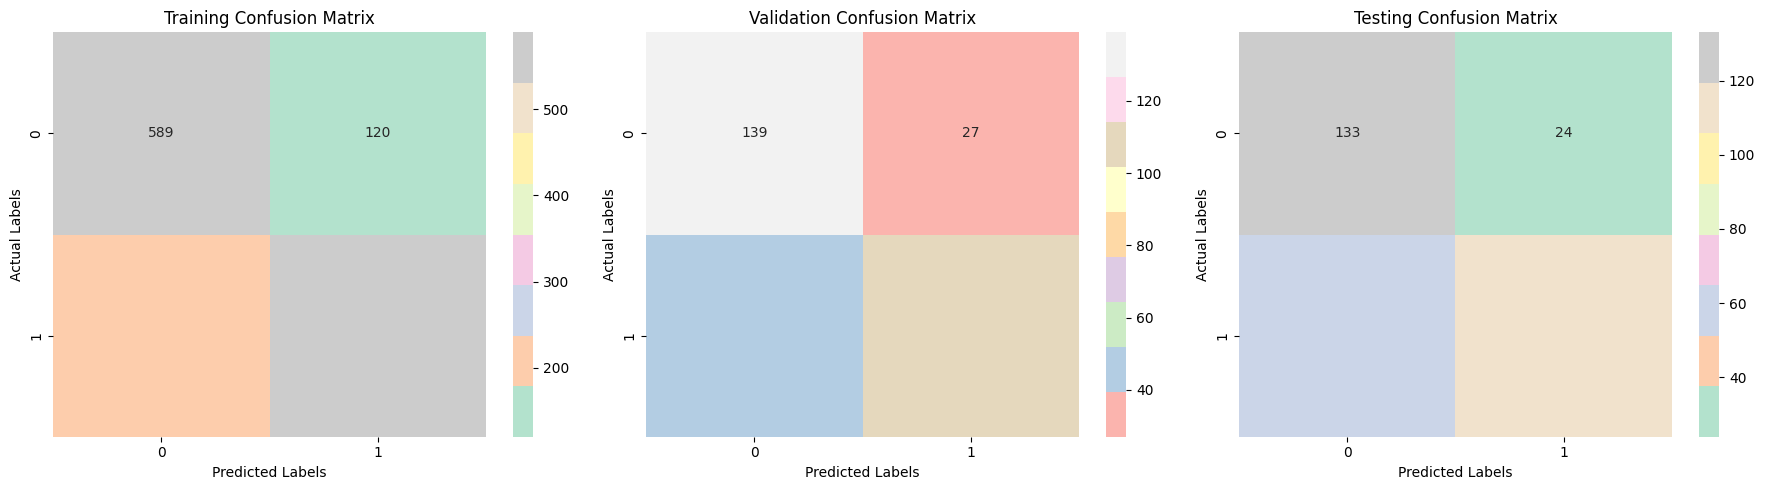

11/11 [==============================] - 4s 325ms/step
Training Set:
Accuracy: 0.7724867724867724
F1 Score: 0.7709720372836218
Loss: 0.4932086169719696
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       709
           1       0.83      0.72      0.77       803

    accuracy                           0.77      1512
   macro avg       0.78      0.78      0.77      1512
weighted avg       0.78      0.77      0.77      1512



Validation Set:
Accuracy: 0.7654320987654321
F1 Score: 0.7414965986394559
Loss: 0.5019382238388062
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       166
           1       0.80      0.69      0.74       158

    accuracy                           0.77       324
   macro avg       0.77      0.76      0.76       324
weighted avg       0.77      0.77      0.76       324



Test Set:
Accuracy: 0.7407407407407407
F1 Sco

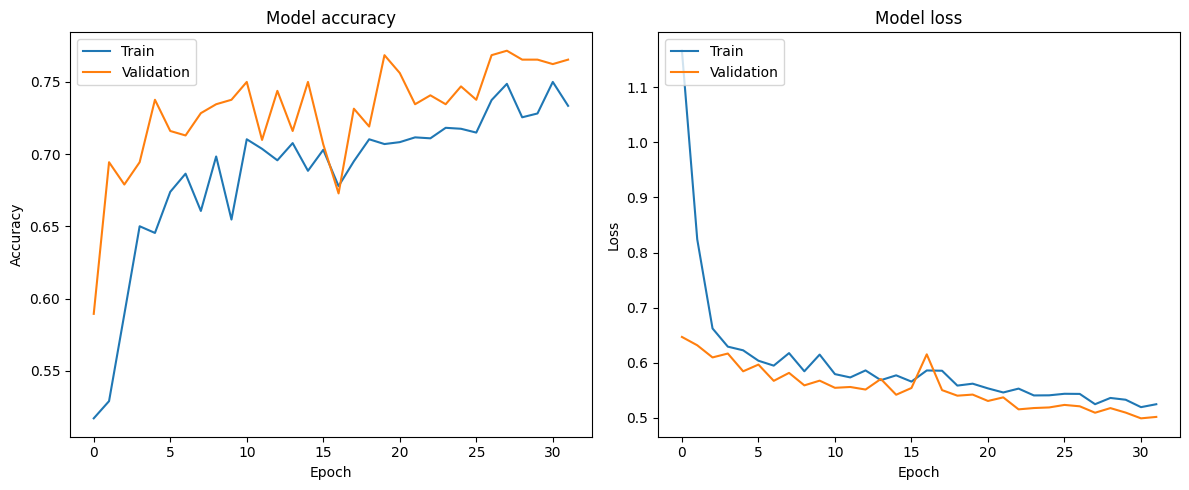

In [29]:
evaluate_model(ResNet50_model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(ResNet50_model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

plot_learning_curves(history)

## Inception



The Inception model for binary classification utilizes a deep learning architecture called InceptionV3. It extracts features from images through multiple convolutional layers and employs global average pooling for dimensionality reduction. Dropout layers help prevent overfitting, while dense layers and a final sigmoid activation function produce binary classification results. This model is effective for tasks like distinguishing between two classes in images.

In [30]:
def build_and_train_inception_model(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define the base model using InceptionV3
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout added
    predictions = Dense(1, activation='sigmoid')(x)
    InceptionV3model = Model(inputs=base_model.input, outputs=predictions)

    InceptionV3model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the model with early stopping
    start_time = time.time()
    history_InceptionV3model = InceptionV3model.fit(X_train, y_train, epochs=32, batch_size=100, validation_data=(X_val, y_val), callbacks=[early_stopping])
    end_time = time.time()
    training_time = end_time - start_time
    
    # Evaluate the model on train, validation, and test sets
    train_loss, train_accuracy = InceptionV3model.evaluate(X_train, y_train, verbose=0)
    y_train_pred = InceptionV3model.predict(X_train)
    train_cm = confusion_matrix(y_train, y_train_pred > 0.5)

    val_loss, val_accuracy = InceptionV3model.evaluate(X_val, y_val, verbose=0)
    y_val_pred = InceptionV3model.predict(X_val)
    val_cm = confusion_matrix(y_val, y_val_pred > 0.5)

    start_time = time.time()
    test_loss, test_accuracy = InceptionV3model.evaluate(X_test, y_test, verbose=0)
    end_time = time.time()
    evaluate_time = end_time - start_time

    start_time = time.time()
    y_test_pred = InceptionV3model.predict(X_test)
    end_time = time.time()
    predict_time = end_time - start_time

    test_cm = confusion_matrix(y_test, y_test_pred > 0.5)

    print("Training Time:", training_time)
    print("Evaluation Time:", evaluate_time)
    print("Prediction Time:", predict_time)

    print("\nTraining Confusion Matrix:")
    print(train_cm)
    print("\nValidation Confusion Matrix:")
    print(val_cm)
    print("\nTest Confusion Matrix:")
    print(test_cm)

        # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_pred > 0.5)

    loss = InceptionV3model.evaluate(X_test, y_test, verbose=0)[0]

    # Calculate F1 score
    f1 = f1_score(y_test, y_test_pred > 0.5)

    # Print or use these metrics as needed
    print("Accuracy:", accuracy)
    print("Loss:", loss)
    print("F1 Score:", f1)


    # Calculate approximate memory usage based on model trainable variables
    total_parameters = 0
    for variable in InceptionV3model.trainable_variables:
        shape = variable.shape
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim
        total_parameters += variable_parameters

    approximate_memory = total_parameters * 4  # Assuming each parameter is a float32 (4 bytes)
    print("Approximate memory usage of the model (in bytes):", approximate_memory)

    # Display model summary to get an estimate of memory usage
    print(InceptionV3model.summary())

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, InceptionV3model, history_InceptionV3model


In [31]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, InceptionV3model, history_InceptionV3model = build_and_train_inception_model(X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/32
16/16 [==============================] - 61s 3s/step - loss: 0.5755 - accuracy: 0.6938 - val_loss: 0.7054 - val_accuracy: 0.6667
Epoch 2/32
16/16 [==============================] - 42s 3s/step - loss: 0.2099 - accuracy: 0.9405 - val_loss: 0.4608 - val_accuracy: 0.8056
Epoch 3/32
16/16 [==============================] - 45s 3s/step - loss: 0.0490 - accuracy: 0.9947 - val_loss: 0.3049 - val_accuracy: 0.9012
Epoch 4/32
16/16 [==============================] - 45s 3s/step - loss: 0.0147 - accuracy: 0.9987 - val_loss: 0.2524 - val_accuracy: 0.9290
Epoch 5/32
16/16 [==============================] - 45s 3s/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.1226 - val_accuracy: 0.9599
Epoch 6/32
16/16 [==============================] - 42s 3s/step - loss: 0.0082 - accuracy: 0.9993 - val_loss: 0.0820 - val_accuracy: 0.9691
Epoch 7/32
16/16 [==============================] - 45s 3s/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0638 - val_accuracy: 0.9691
Epoch 8/32
16/16 [==

11/11 [==============================] - 2s 164ms/step


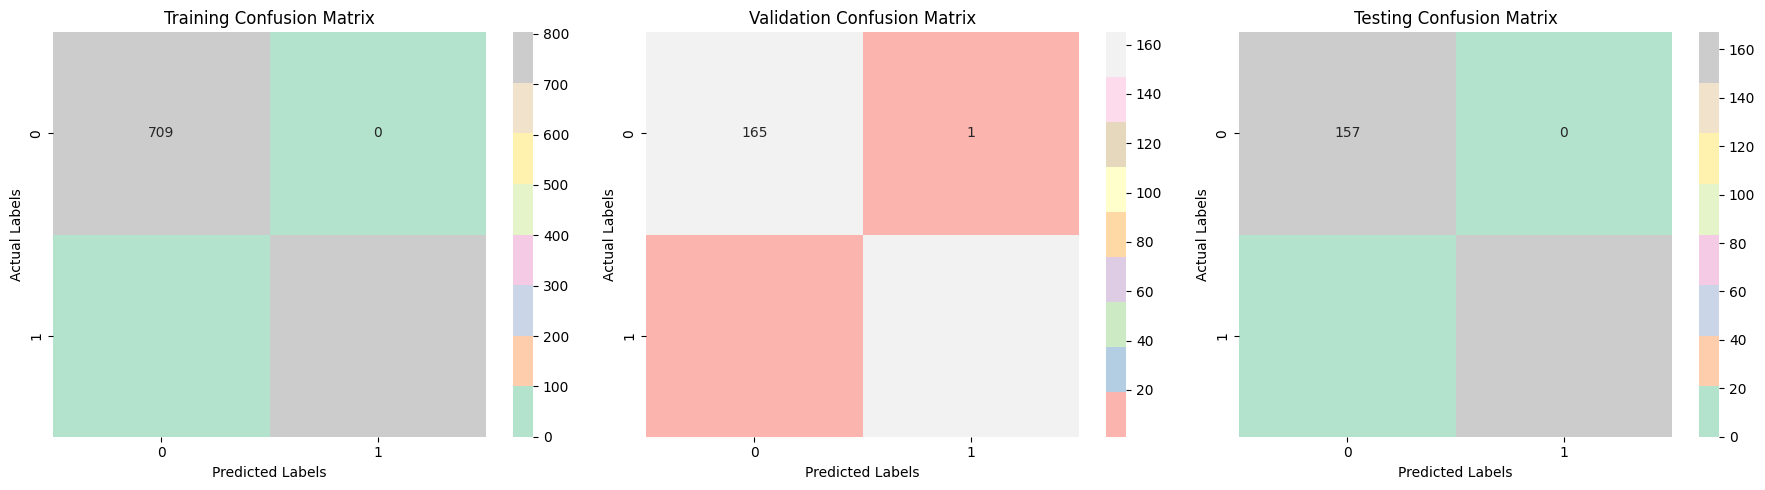

11/11 [==============================] - 2s 157ms/step
Training Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.001583955599926412
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       709
           1       1.00      1.00      1.00       803

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



Validation Set:
Accuracy: 0.9938271604938271
F1 Score: 0.9936708860759493
Loss: 0.01032974198460579
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       166
           1       0.99      0.99      0.99       158

    accuracy                           0.99       324
   macro avg       0.99      0.99      0.99       324
weighted avg       0.99      0.99      0.99       324



Test Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.007538527715951204
Classif

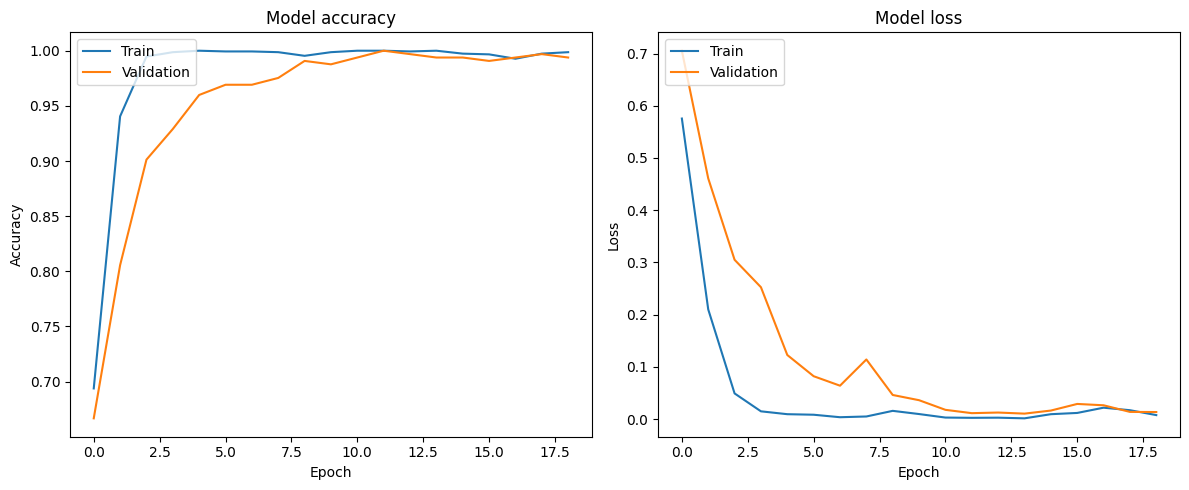

In [32]:
Inc_train_cm,Inc_val_cm,Inc_test_cm = evaluate_model(InceptionV3model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(InceptionV3model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

plot_learning_curves(history_InceptionV3model)

In [33]:
print(Inc_train_cm)
print(Inc_val_cm)
print(Inc_test_cm)

[[709   0]
 [  0 803]]
[[165   1]
 [  1 157]]
[[157   0]
 [  0 167]]


## InceptionResNetV2

The InceptionResNetV2_Model function is intended for image classification tasks using the InceptionResNetV2 architecture. It takes in training, validation, and test data along with a pre-initialized InceptionResNetV2 model. The function then configures the model with an Adam optimizer using a binary cross-entropy loss function and accuracy as the metric. It fits the model to the provided training data for a specified number of epochs, utilizing the validation data for validation during training.

The function computes various evaluation metrics such as loss, accuracy, and confusion matrix for the training, validation, and test sets. Finally, it returns these evaluation metrics along with the trained model for further analysis.

In [34]:
def build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test):
    # Load the Inception-ResNetV2 model
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the final model
    InceptionResNetV2model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    InceptionResNetV2model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history_InceptionResNetV2 = InceptionResNetV2model.fit(X_train, y_train, epochs=32, validation_data=(X_val, y_val))
    end_time = time.time()
    training_time = end_time - start_time
    
    # Evaluate the model on train, validation, and test sets
    train_loss, train_accuracy = InceptionResNetV2model.evaluate(X_train, y_train, verbose=0)
    y_train_pred = InceptionResNetV2model.predict(X_train)
    train_cm = confusion_matrix(y_train, y_train_pred > 0.5)

    val_loss, val_accuracy = InceptionResNetV2model.evaluate(X_val, y_val, verbose=0)
    y_val_pred = InceptionResNetV2model.predict(X_val)
    val_cm = confusion_matrix(y_val, y_val_pred > 0.5)

    start_time = time.time()
    test_loss, test_accuracy = InceptionResNetV2model.evaluate(X_test, y_test, verbose=0)
    end_time = time.time()
    evaluate_time = end_time - start_time

    start_time = time.time()
    y_test_pred = InceptionResNetV2model.predict(X_test)
    end_time = time.time()
    predict_time = end_time - start_time

    test_cm = confusion_matrix(y_test, y_test_pred > 0.5)

    print("Training Time:", training_time)
    print("Evaluation Time:", evaluate_time)
    print("Prediction Time:", predict_time)

    print("\nTraining Confusion Matrix:")
    print(train_cm)
    print("\nValidation Confusion Matrix:")
    print(val_cm)
    print("\nTest Confusion Matrix:")
    print(test_cm)

        # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_pred > 0.5)

    loss = InceptionResNetV2model.evaluate(X_test, y_test, verbose=0)[0]

    # Calculate F1 score
    f1 = f1_score(y_test, y_test_pred > 0.5)

    # Print or use these metrics as needed
    print("Accuracy:", accuracy)
    print("Loss:", loss)
    print("F1 Score:", f1)


    # Calculate approximate memory usage based on model trainable variables
    total_parameters = 0
    for variable in InceptionResNetV2model.trainable_variables:
        shape = variable.shape
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim
        total_parameters += variable_parameters

    approximate_memory = total_parameters * 4  # Assuming each parameter is a float32 (4 bytes)
    print("Approximate memory usage of the model (in bytes):", approximate_memory)

    # Display model summary to get an estimate of memory usage
    print(InceptionV3model.summary())

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, InceptionResNetV2model, history_InceptionResNetV2


In [35]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, InceptionResNetV2model, history_InceptionResNetV2 = build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test)


Epoch 1/32
48/48 [==============================] - 44s 668ms/step - loss: 0.7240 - accuracy: 0.6574 - val_loss: 0.4241 - val_accuracy: 0.7994
Epoch 2/32
48/48 [==============================] - 26s 544ms/step - loss: 0.4884 - accuracy: 0.7976 - val_loss: 0.3458 - val_accuracy: 0.8519
Epoch 3/32
48/48 [==============================] - 27s 558ms/step - loss: 0.3330 - accuracy: 0.8578 - val_loss: 0.2932 - val_accuracy: 0.9012
Epoch 4/32
48/48 [==============================] - 26s 538ms/step - loss: 0.2772 - accuracy: 0.8955 - val_loss: 0.2524 - val_accuracy: 0.9259
Epoch 5/32
48/48 [==============================] - 26s 534ms/step - loss: 0.2369 - accuracy: 0.9134 - val_loss: 0.2172 - val_accuracy: 0.9444
Epoch 6/32
48/48 [==============================] - 25s 533ms/step - loss: 0.1959 - accuracy: 0.9345 - val_loss: 0.2071 - val_accuracy: 0.9475
Epoch 7/32
48/48 [==============================] - 27s 556ms/step - loss: 0.1620 - accuracy: 0.9563 - val_loss: 0.1954 - val_accuracy: 0.9475

11/11 [==============================] - 4s 393ms/step


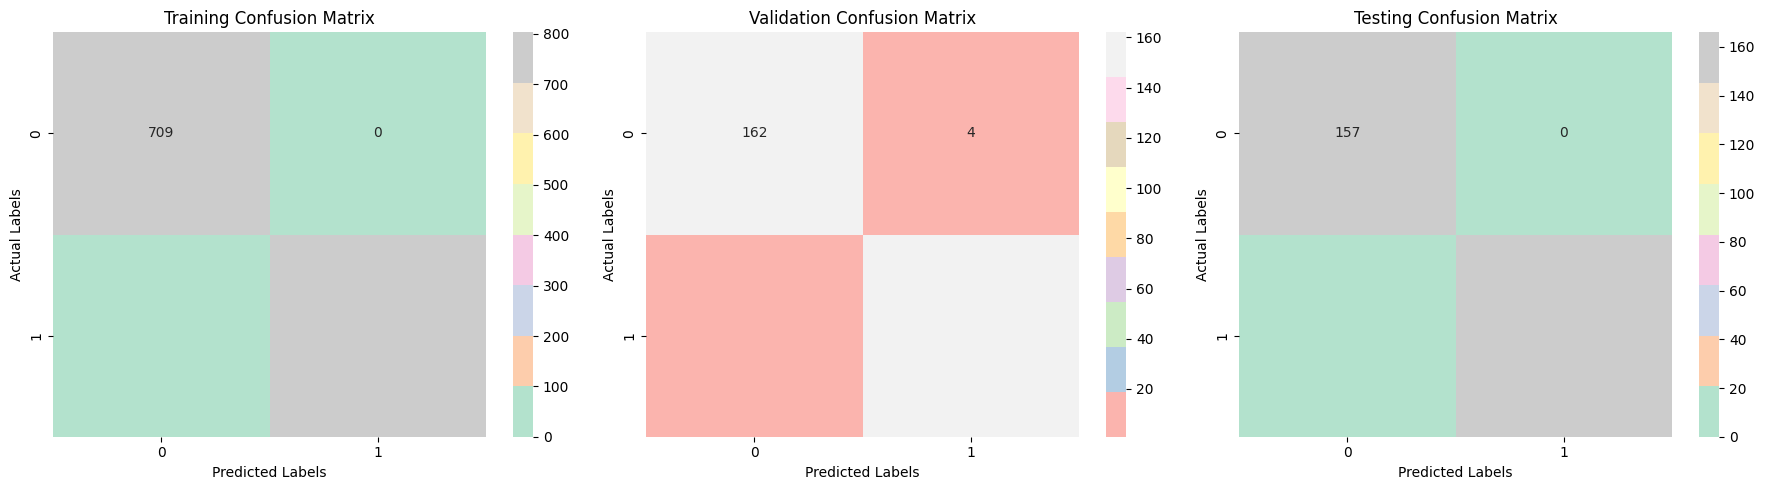

11/11 [==============================] - 5s 419ms/step
Training Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.007085143588483334
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       709
           1       1.00      1.00      1.00       803

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



Validation Set:
Accuracy: 0.9845679012345679
F1 Score: 0.9843260188087773
Loss: 0.0733160749077797
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       166
           1       0.98      0.99      0.98       158

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weighted avg       0.98      0.98      0.98       324



Test Set:
Accuracy: 0.9969135802469136
F1 Score: 0.996996996996997
Loss: 

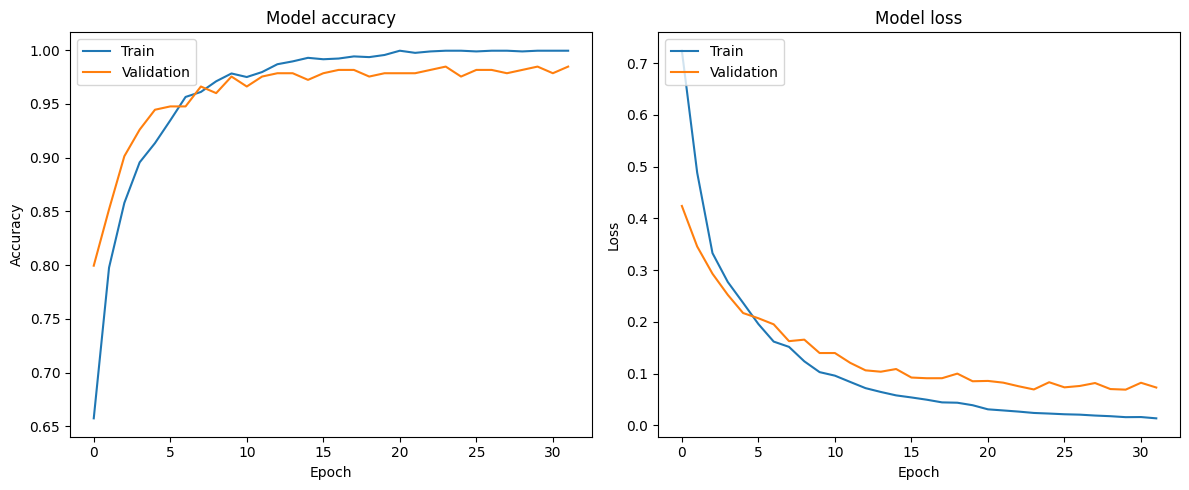

In [36]:
evaluate_model(InceptionResNetV2model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(InceptionResNetV2model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

plot_learning_curves(history_InceptionResNetV2)

## MobileNetV2

MobileNetV2 is a lightweight deep learning model designed for efficient deployment on resource-constrained devices like mobile phones and embedded systems. It leverages depth-wise separable convolutions to reduce computational complexity while maintaining high accuracy in image recognition tasks. This architecture allows MobileNetV2 to achieve state-of-the-art performance on various tasks, making it a popular choice for mobile applications requiring real-time image processing. Its compact size and impressive performance make it a versatile option for a wide range of computer vision applications on devices with limited computational resources.

In [37]:
def build_and_train_mobilenetv2(X_train, y_train, X_val, y_val, X_test, y_test):
    # Load the MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the final model
    MobileNetV2model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    MobileNetV2model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history_MobileNetV2 = MobileNetV2model.fit(X_train, y_train, epochs=32, validation_data=(X_val, y_val))
    end_time = time.time()
    training_time = end_time - start_time
    
    # Evaluate the model on train, validation, and test sets
    train_loss, train_accuracy = MobileNetV2model.evaluate(X_train, y_train, verbose=0)
    y_train_pred = MobileNetV2model.predict(X_train)
    train_cm = confusion_matrix(y_train, y_train_pred > 0.5)

    val_loss, val_accuracy = MobileNetV2model.evaluate(X_val, y_val, verbose=0)
    y_val_pred = MobileNetV2model.predict(X_val)
    val_cm = confusion_matrix(y_val, y_val_pred > 0.5)

    start_time = time.time()
    test_loss, test_accuracy = MobileNetV2model.evaluate(X_test, y_test, verbose=0)
    end_time = time.time()
    evaluate_time = end_time - start_time

    start_time = time.time()
    y_test_pred = MobileNetV2model.predict(X_test)
    end_time = time.time()
    predict_time = end_time - start_time

    test_cm = confusion_matrix(y_test, y_test_pred > 0.5)

    print("Training Time:", training_time)
    print("Evaluation Time:", evaluate_time)
    print("Prediction Time:", predict_time)

    print("\nTraining Confusion Matrix:")
    print(train_cm)
    print("\nValidation Confusion Matrix:")
    print(val_cm)
    print("\nTest Confusion Matrix:")
    print(test_cm)

        # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_pred > 0.5)

    loss = MobileNetV2model.evaluate(X_test, y_test, verbose=0)[0]

    # Calculate F1 score
    f1 = f1_score(y_test, y_test_pred > 0.5)

    # Print or use these metrics as needed
    print("Accuracy:", accuracy)
    print("Loss:", loss)
    print("F1 Score:", f1)


    # Calculate approximate memory usage based on model trainable variables
    total_parameters = 0
    for variable in MobileNetV2model.trainable_variables:
        shape = variable.shape
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim
        total_parameters += variable_parameters

    approximate_memory = total_parameters * 4  # Assuming each parameter is a float32 (4 bytes)
    print("Approximate memory usage of the model (in bytes):", approximate_memory)

    # Display model summary to get an estimate of memory usage
    print(InceptionV3model.summary())

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, MobileNetV2model, history_MobileNetV2

In [38]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, MobileNetV2model, history_MobileNetV2 = build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test)


Epoch 1/32
48/48 [==============================] - 43s 648ms/step - loss: 0.8052 - accuracy: 0.6468 - val_loss: 0.4515 - val_accuracy: 0.7840
Epoch 2/32
48/48 [==============================] - 27s 562ms/step - loss: 0.4959 - accuracy: 0.7837 - val_loss: 0.3458 - val_accuracy: 0.8580
Epoch 3/32
48/48 [==============================] - 26s 546ms/step - loss: 0.3584 - accuracy: 0.8287 - val_loss: 0.2981 - val_accuracy: 0.8796
Epoch 4/32
48/48 [==============================] - 26s 537ms/step - loss: 0.2851 - accuracy: 0.8902 - val_loss: 0.2617 - val_accuracy: 0.9012
Epoch 5/32
48/48 [==============================] - 26s 535ms/step - loss: 0.2430 - accuracy: 0.9067 - val_loss: 0.2199 - val_accuracy: 0.9352
Epoch 6/32
48/48 [==============================] - 27s 557ms/step - loss: 0.1927 - accuracy: 0.9312 - val_loss: 0.2082 - val_accuracy: 0.9414
Epoch 7/32
48/48 [==============================] - 27s 554ms/step - loss: 0.1617 - accuracy: 0.9524 - val_loss: 0.1775 - val_accuracy: 0.9599

11/11 [==============================] - 5s 422ms/step


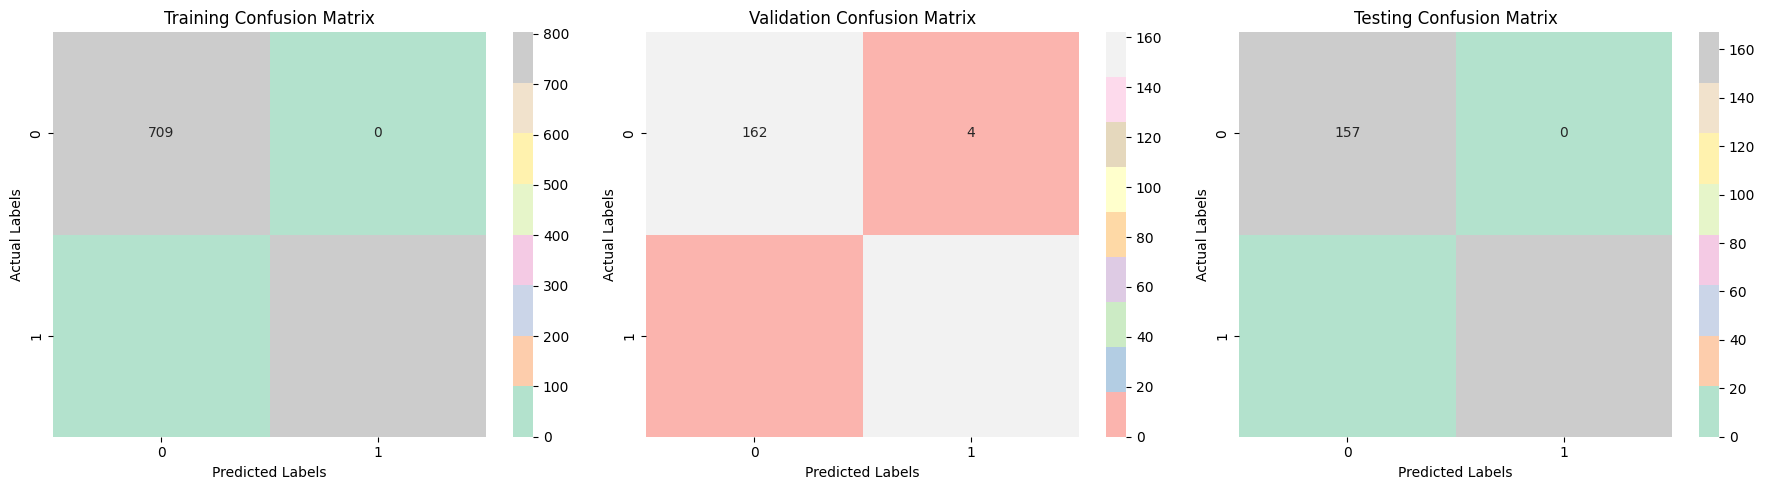

11/11 [==============================] - 4s 403ms/step
Training Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.0066777910105884075
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       709
           1       1.00      1.00      1.00       803

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



Validation Set:
Accuracy: 0.9876543209876543
F1 Score: 0.9875
Loss: 0.07053776830434799
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       166
           1       0.98      1.00      0.99       158

    accuracy                           0.99       324
   macro avg       0.99      0.99      0.99       324
weighted avg       0.99      0.99      0.99       324



Test Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.025196287781000137
Classification Rep

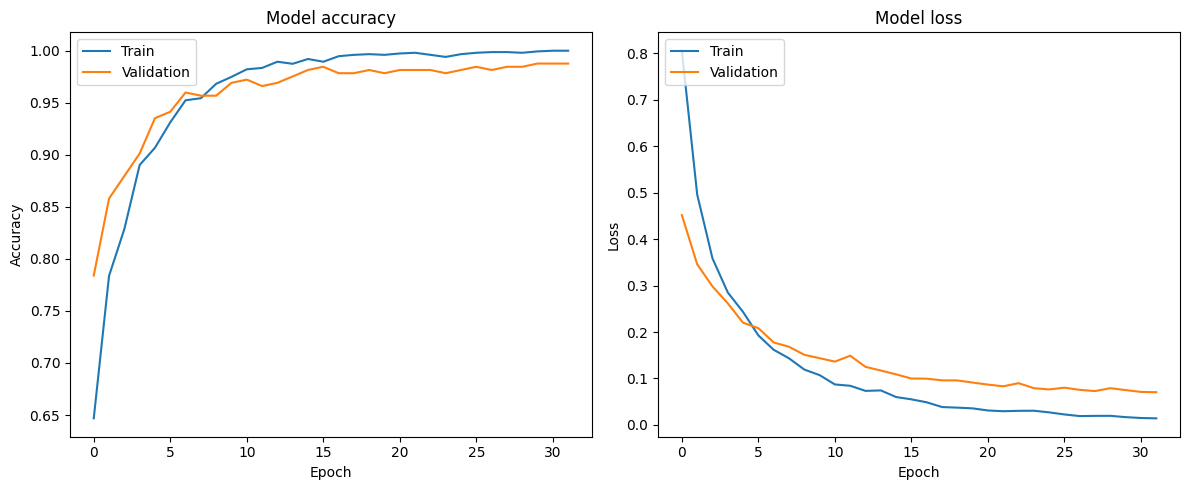

In [39]:
evaluate_model(MobileNetV2model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(MobileNetV2model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

plot_learning_curves(history_MobileNetV2)

## Yolo v8

YOLO (You Only Look Once) v8 is a state-of-the-art binary classification model. It uses a single pass through the network to simultaneously detect and classify objects. YOLO v8 achieves exceptional speed and accuracy by dividing the image into a grid, predicting bounding boxes and class probabilities. This allows for real-time performance in applications like object recognition.

In [69]:
import os
from ultralytics import YOLO
from PIL import Image

the_object='toy'
dir="E:\YoloCVShenhapy"

In [70]:
train_data, temp_data = train_test_split(df_copy, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

## Functions

In [71]:
def creat_directory(base_dir,the_object):
    # Creating Folders for yolo
    os.makedirs(the_object, exist_ok=True)

    classes = ['True', 'False']

    # Define the split types (train, test, val)
    splits = ['train', 'test', 'val']

    # Create directories
    for split in splits:
        split_dir = os.path.join(base_dir, the_object, split)
        os.makedirs(split_dir, exist_ok=True)
        for class_name in classes:
            class_dir = os.path.join(split_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)

def save_images(base_dir, data, split_type, the_object):
    for index, row in data.iterrows():
        img_array = row['img']
        class_label = row['z']

        class_name = 'True' if class_label == 1 else 'False'

        image_filename = f"{class_name}_{index}.jpg"
        image_path = os.path.join(base_dir, the_object, split_type, class_name, image_filename)

        image_filename = f"{class_name}_{index}.jpg"
        image_path = os.path.join(base_dir, the_object, split_type, class_name, image_filename)

        image = Image.fromarray(img_array)
        image.save(image_path)
    print(image_path)
        
def calculate_cm(true, false):
    counts=[]
    for result in true:
        probs = result.probs.data.tolist()
        # print(probs)
        index = probs.index(max(probs))
        counts.append(index)
    TP = counts.count(1)
    FN = counts.count(0)

    counts1=[]
    for result in false:
        probs = result.probs.data.tolist()
        # print(probs)
        index = probs.index(max(probs))
        counts1.append(index)
    TN = counts1.count(0)
    FP = counts1.count(1)

    confusion_matrix_data = [[TN, FP], [FN, TP]]

    print("TP:",TP)
    print("FP:",FP)
    print("TN:",TN)
    print("FN:",FN)

    return TP, TN, FP, FN


def plot_confusion_matrix1(TP, TN, FP, FN):
    confusion_matrix = np.array([[TN, FN],
                                    [FP, TP]])

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Pastel2)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks_y = np.arange(2)
    plt.yticks(tick_marks_y, ["0", "1"], rotation=0)

    tick_marks_x = np.arange(2)
    plt.xticks(tick_marks_x, ["0", "1"], rotation=0)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment="center", color="black")

    plt.tight_layout()
    plt.show()

## yolo Function

In [72]:
def yolov8(dir, the_object, train_data, val_data, test_data):
    creat_directory(dir, the_object)
    # Save images for train, validation,z and test sets
    save_images(dir, train_data, 'train', the_object)
    save_images(dir, val_data, 'val', the_object)
    save_images(dir, test_data, 'test', the_object)

    # Load a model
    model = YOLO("yolov8n-cls.pt")  # load a pretained model

    # Use the model
    start_time = time.time()
    data = os.path.join(dir, the_object)
    results = model.train(data=data, epochs=3, imgsz=128)  # train the model
    end_time = time.time()
    training_time = end_time - start_time

    print("Training Time:", training_time)

def yolo_eval(best, dir, the_object,):
    model = YOLO(best)  # load a custom model

    # Predict with the model
    Train_True = os.path.join(dir, the_object, 'train', 'True')
    Train_False = os.path.join(dir, the_object, 'train', 'False')
    val_True = os.path.join(dir, the_object, 'val', 'True')
    val_False = os.path.join(dir, the_object, 'val', 'False')
    Test_True = os.path.join(dir, the_object, 'test', 'True')
    Test_False = os.path.join(dir, the_object, 'test', 'False')

    shoe_train = model(Train_True)  # predict on an image
    no_shoe_train = model(Train_False)  # predict on an image

    shoe_val = model(val_True)  # predict on an image
    no_shoe_val = model(val_False)  # predict on an image

    start_time = time.time()
    shoe_test = model(Test_True)  # predict on an image
    no_shoe_test = model(Test_False)  # predict on an image
    end_time = time.time()
    predict_time = end_time - start_time

    
    print("Prediction Time:", predict_time)

    TP, TN, FP, FN = calculate_cm(shoe_test, no_shoe_test)

    plot_confusion_matrix1(TP, TN, FP, FN)

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate Precision
    precision = TP / (TP + FP)

    # Calculate Recall
    recall = TP / (TP + FN)

    # Calculate F1-Score
    f1 = (2 * precision * recall) / (precision + recall)

    print("Test Accuracy:", accuracy)
    print("Test Recall:", recall)
    print("Test Precision:", precision)
    print("Test F1-score:", f1)
    

In [73]:
yolov8(dir, the_object, train_data, val_data, test_data)

E:\YoloCVShenhapy\toy\train\False\False_860.jpg
E:\YoloCVShenhapy\toy\val\True\True_1362.jpg


E:\YoloCVShenhapy\toy\test\True\True_1231.jpg


100%|██████████| 5.28M/5.28M [00:00<00:00, 14.1MB/s]
New https://pypi.org/project/ultralytics/8.0.211 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.208  Python-3.11.5 torch-2.0.1+cpu CPU (Intel Core(TM) i7-10700 2.90GHz)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=E:\YoloCVShenhapy\toy, epochs=3, patience=50, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer

Training Time: 56.84801197052002



image 1/803 E:\YoloCVShenhapy\toy\train\True\True_101.jpg: 128x128 True 1.00, False 0.00, 5.0ms
image 2/803 E:\YoloCVShenhapy\toy\train\True\True_102.jpg: 128x128 True 1.00, False 0.00, 6.0ms
image 3/803 E:\YoloCVShenhapy\toy\train\True\True_103.jpg: 128x128 True 1.00, False 0.00, 4.0ms
image 4/803 E:\YoloCVShenhapy\toy\train\True\True_104.jpg: 128x128 True 1.00, False 0.00, 5.0ms
image 5/803 E:\YoloCVShenhapy\toy\train\True\True_106.jpg: 128x128 True 1.00, False 0.00, 6.0ms
image 6/803 E:\YoloCVShenhapy\toy\train\True\True_107.jpg: 128x128 True 1.00, False 0.00, 5.0ms
image 7/803 E:\YoloCVShenhapy\toy\train\True\True_108.jpg: 128x128 True 1.00, False 0.00, 5.0ms
image 8/803 E:\YoloCVShenhapy\toy\train\True\True_1080.jpg: 128x128 True 1.00, False 0.00, 5.0ms
image 9/803 E:\YoloCVShenhapy\toy\train\True\True_1081.jpg: 128x128 True 1.00, False 0.00, 5.0ms
image 10/803 E:\YoloCVShenhapy\toy\train\True\True_1082.jpg: 128x128 True 1.00, False 0.00, 5.0ms
image 11/803 E:\YoloCVShenhapy\toy\

Prediction Time: 4.989836931228638
TP: 167
FP: 0
TN: 157
FN: 0


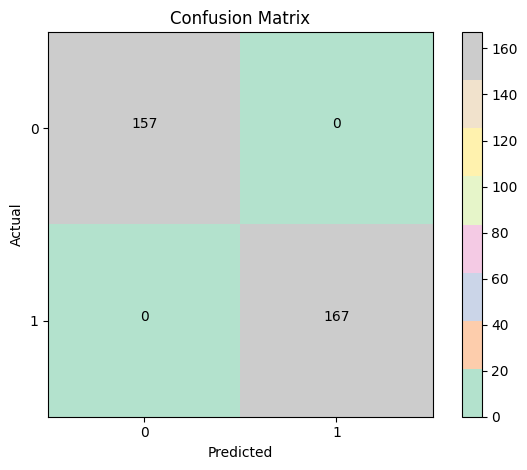

Test Accuracy: 1.0
Test Recall: 1.0
Test Precision: 1.0
Test F1-score: 1.0


In [74]:
best_dir= r"E:\OneDrive - University of Ottawa\CV\CV Project\3abilation\runs\classify\train\weights\best.pt"

yolo_eval(best_dir, dir, the_object)

From the previous evaluation results, it appears that the InceptionResNetV2 and Yolo v8 models achieve higher performance.

In [75]:
model = YOLO(best_dir)